# IBM  Db2 Event Store Lab / Demo

<p>This code provides some basic manipulation of the Event Store database.</p>

## 1.  Connect to IBM Db2 Event Store
To establish a connection to IBM Db2 Event Store, you need connection endpoints. Use the configuration reader to provide a set of APIs for Event Store connection and configuration.<br/>
`# ConfigurationReader.setConnectionEndpoints("<HostName>:<PortNumber>")`

You can also specify multiple connection endpoints by providing a connection string that contains comma-separated list of HostName:PortNumber pairs.<br/>
`# ConfigurationReader.setConnectionEndpoints("<HostName1>:<PortNumber1>,<HostName2>:<PortNumber2>,<Hostname3>:<PortNumber3>")` 

Using the configuration reader API, set up the userID and password that will be used to connect to Event Store.

Note that the `ConnectionEndpoint` IP address should be the same as in your browser URL.

In [1]:
from eventstore.oltp import EventContext
from eventstore.oltp.row_generator import generate_tele
from eventstore.catalog import TableSchema, IndexSpecification, SortSpecification, ColumnOrder
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from eventstore.common import ConfigurationReader

spark = SparkSession.builder.getOrCreate()
ConfigurationReader.setConnectionEndpoints("169.48.209.252:1100") # This should be the same IP address as this browser page
ConfigurationReader.setEventUser("admin")
ConfigurationReader.setEventPassword("password")
spark.version

u'2.0.2'

## 2. Define a database  
Only one database can be active in Db2 Event Store. If you already have a database, you don't need to create one.<br/>
To create a database in Event Store, you can use the `createDatabase` method 

In [2]:
# EventContext.drop_database("TESTDB") # uncomment this line if you need to first drop the database
EventContext.create_database("TESTDB")

###  2.1 Open an existing database
To use an existing database, use the following call:

In [3]:
ctx = EventContext.get_event_context("TESTDB")

<a id="create-table"></a>
## 3. Create your table

### 3.1 Define a schema for the table
To create a new table, you must first specify a schema for the table.
Specify the columns, sharding key, and primary key, as required.<br/>
Note that currently String is not supported as a primary key or sharding key.<br/>
<i>The `timestamp` is not supported in the first release but still works</i>

In [4]:
from eventstore.catalog import TableSchema
from pyspark.sql.types import *

schema = StructType([
        StructField("id", LongType(), nullable = False),
        StructField("taxiId", StringType(), nullable = True),
        StructField("tripId", StringType(), nullable = True),
        StructField("tripStartTime", TimestampType(), nullable = True),
        StructField("tripEndTime", TimestampType(), nullable = True),
        StructField("pickupLong", DoubleType(), nullable = True),
        StructField("pickupLat", DoubleType(), nullable = True),
        StructField("dropoffLong", DoubleType(), nullable = True),
        StructField("dropoffLat", DoubleType(), nullable = True),
        StructField("tripTotal", DoubleType(), nullable = True),
        StructField("tripMiles", DoubleType(), nullable = True),
        StructField("tripSeconds", DoubleType(), nullable = True)
])  
table_schema = TableSchema("TaxiTrips", schema,
                            sharding_columns=["id"],
                            pk_columns=["id"])

<b>Tip:</b> Databases in Event Store are partitioned into shards. Any Event Store node of a multi-node Event Store cluster contains 0, 1 or N shards of the defined database. In addition to the mandatory shard key, there is also the option to provide a primary key. When this key is defined, Event Store ensures that only a single version of each primary key exists in the database.

In the above example, a sharding key and a primary key are defined on column id. 

<a id="create-table-two"></a>
### 3.2 Create the table
Create the Event Store table based on the above, unresolved schema.

In [5]:
ctx.create_table(table_schema)
table_names = ctx.get_names_of_tables()
for idx, name in enumerate(table_names):
    print(name)

TaxiTrips


### 3.3 Start the insertion program
There is a deamon program running on the machine that waits for a command to start the insertion
<ul>
<li>IP address: ignored in this environment</li>
<li>rate      : records per second insertion rate</li>
<li>db name   : name of the database used</li>
<li>table name: name of the table</li>
</ul>

In [6]:
import socket               # Import socket module

s = socket.socket()         # Create a socket object

host = "169.48.209.252"    # same address as the URL in this browser
port = 9292                # Port used vy the deamon program

s.connect((host, port))
# <ip address>,<rate>,<db name>,<table name>
msg = "9.80.91.202,100,TESTDB,TaxiTrips\n"
s.send(msg.encode())
ret = s.recv(1024).decode()
s.close
print(ret)

Insert process started



## 4. Query the table 

<a id="connect-to-es-two"></a>
### 4.1 Connect to  Event Store 

When connecting Event Store for the first time, you need to provide connection endpoints using the configuration reader.<br/>
If you are in the same session that created the database and table, you don't need to execute this step.<br/>
If you are in a new session, make sure you executed step 1.

### 4.2 Create EventSession

To run a Spark SQL query, you need to establish an Event Store Spark session.

In [7]:
from eventstore.sql import EventSession

eventSession = EventSession(spark.sparkContext, "TESTDB")
eventSession.open_database()
eventSession.set_query_read_option("SnapshotNone")

### 4.3 Prepare a DataFrame for the query 
The following API provides a DataFrame that holds the query results on the Event Store table. 

In [8]:
reviewTab = eventSession.load_event_table("TaxiTrips")
reviewTab.createOrReplaceTempView("TaxiTrips")

### 4.4 Run the SQL query
Now you can materialize the dataframe associated with the sql query by using show().

In [10]:
resultSet1 = eventSession.sql("SELECT count(*) as totalRows FROM TaxiTrips")
resultSet1.show()

+---------+
|totalRows|
+---------+
|    10700|
+---------+



This query shows an aggregation. Since it is executed after the previous one you should see a larger number of total records

In [11]:
resultSet2 = eventSession.sql("""
SELECT tripStartTime, count(*) as count, avg(tripTotal) as AvgTotal,
                      avg(tripMiles) as AvgMiles, avg(tripSeconds) as AvgDuration
FROM TaxiTrips
GROUP BY tripStartTime
ORDER BY tripStartTime
""")
resultSet2.show()

+--------------------+-----+------------------+------------------+-----------------+
|       tripStartTime|count|          AvgTotal|          AvgMiles|      AvgDuration|
+--------------------+-----+------------------+------------------+-----------------+
|2013-01-01 06:00:...|  573|10.870471204188485|2.5656719022687593|566.6666666666666|
|2013-01-01 06:15:...| 1368| 23.76663011695905| 3.043764619883037|560.2351212343865|
|2013-01-01 06:30:...| 1486|19.510397039030956|2.9795020188425316|579.1216216216217|
|2013-01-01 06:45:...| 1294|16.748902627511598| 2.677241112828437|566.2295081967213|
|2013-01-01 07:00:...| 1235|18.931983805668004|2.8173441295546553|635.9901800327332|
|2013-01-01 07:15:...| 1574|13.638074968233816| 2.667280813214737|600.1533546325878|
|2013-01-01 07:30:...| 1912|15.658770920502079|2.6289121338912147|614.5637228979376|
|2013-01-01 07:45:...| 1948|13.373942505133481|2.7539065708418873|633.5677352637022|
|2013-01-01 08:00:...| 1945| 17.61454498714653|2.9372082262210744

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

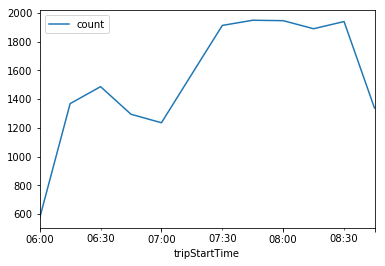

In [13]:
resultSet2.toPandas().plot(kind='line', x='tripStartTime', y='count');

### You can stop the loader program with the following cell
Otherwise, it automatically stops after 30 minutes

In [14]:
# Stop the loader program
s = socket.socket()
s.connect((host, port))
msg = "stop\n"
s.send(msg.encode())
ret = s.recv(1024).decode()
s.close
print(ret)

Insert process stopped

